In [116]:
import pandas as pd
import torch
import torch.nn.functional as F
from StockAnomaly import StockAnomaly
import numpy as np
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA


from transformers import (AutoModelForSequenceClassification,
                          pipeline,
                          AutoTokenizer)

# data = pd.read_parquet('scraped_data.parquet')

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
BERTmodel = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
classifier = pipeline('text-classification',model=BERTmodel,tokenizer=tokenizer,truncation=True, max_length=512)

def finbert_sentiment(text:str) -> tuple[float,float,float,str]:
    '''https://www.youtube.com/watch?v=FRDKeNEeNAQ&t=640s'''
    with torch.no_grad():
 
        inputs = tokenizer(
            text,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=512     
        )
        
        inputs = {k: v.to(BERTmodel.device) for k, v in inputs.items()}

        outputs = BERTmodel(**inputs)
        
        probs = F.softmax(outputs.logits, dim=-1).squeeze()
        
        id2label = BERTmodel.config.id2label
        scores = {id2label[i]: probs[i].item() for i in range(len(id2label))}

        return (scores['positive'],scores['neutral'],scores['negative'],max(scores,key=scores.get))

def calc_bullishness(group_series):
    """
    Antweiler & Frank (2004) Bullishness Index: B = ln((1 + N_pos) / (1 + N_neg))
    Input: A Series of sentiment labels ('positive', 'neutral', 'negative')
    """
    counts = group_series.value_counts()
    n_pos = counts.get('positive', 0)
    n_neg = counts.get('negative', 0)
    
    return np.log((1 + n_pos) / (1 + n_neg))

def calc_agreement(group_series):
    """
    Antweiler & Frank (2004) Agreement Index:
    Measures consensus. Higher value = High consensus (everyone agrees).
    Lower value = High disagreement or mostly neutral news.
    """
    counts = group_series.value_counts()
    n_pos = counts.get('positive', 0)
    n_neg = counts.get('negative', 0)
    n_neut = counts.get('neutral', 0)
    
    total = n_pos + n_neg + n_neut
    
    if total == 0:
        return 0.0
    
    inner_val = ((n_pos - n_neg) / total) ** 2
    agreement = 1 - np.sqrt(1 - inner_val)
    
    return agreement

def compute_volatility(df):

    # MA 1

    model = ARIMA(df['log_return'], order=(0, 0, 1))
    model_fit = model.fit()    

    df['ln_vi_t'] = np.log(model_fit.resid**2)

    df['ln_vi_t_soxx'] = np.log((df['log_return']-df['soxx_ret'])**2)
    
    return df

def add_ts(metrics):
    stocks = ["AMD", "ASML", "GOOG", "META", "NVDA"]

    stocks_data = yf.Tickers(stocks)
    hist = stocks_data.history(period='5y', interval="1d")
    
    data_subset = hist[['Close', 'Volume', 'Dividends']]
    prices_long = data_subset.stack(level=1).reset_index()
    prices_long.columns = ['date', 'label', 'price', 'volume', 'dividend']

    prices_long['dividend_dummy'] = np.where(prices_long['dividend'] > 0, 1, 0)
    
    prices_long = prices_long.sort_values(['label', 'date'])

    prices_long['log_return'] = prices_long.groupby('label')['price'].transform(
        lambda x: 100*np.log(x/x.shift(1))
    )
    
    prices_long['log_return_lag'] = prices_long.groupby('label')['log_return'].shift(1)
    prices_long['lag_neg'] = np.where(prices_long['log_return_lag']<0,1,0)

    prices_long['log_volume'] = np.log(prices_long['volume'] + 1)

    prices_long['date'] = prices_long['date'].dt.strftime('%Y-%m-%d')

    soxx = yf.Ticker("SOXX").history(period='5y')[['Close']]
    soxx['soxx_ret'] = 100*np.log(soxx['Close']/soxx['Close'].shift(1))
    soxx.index = pd.to_datetime(soxx.index.date).strftime('%Y-%m-%d')
    soxx = soxx[['soxx_ret']].reset_index().rename(columns={'index': 'date'})

    combined_df = prices_long.merge(metrics, on=['date', 'label'], how='left')
    combined_df = combined_df.merge(soxx, on='date', how='left')

    combined_df['bullishness_lag'] = combined_df.groupby('label')['bullishness_index'].shift(1)
    combined_df['agreement_lag'] = combined_df.groupby('label')['agreement_index'].shift(1)
    combined_df['article_count_lag'] = combined_df.groupby('label')['article_count'].shift(1)

    combined_df = combined_df.dropna()

    combined_df.sort_values('date',ascending=True,inplace=True)

    combined_df = combined_df.groupby('label', group_keys=False).apply(compute_volatility)

    return combined_df



Device set to use cuda:0


In [98]:
SENTIMENT_REF_COLUMN = 'fist_parag'

data[['fb_positive','fb_neutral','fb_negative','sentiment']] = data[SENTIMENT_REF_COLUMN].apply(finbert_sentiment).apply(pd.Series)


In [123]:
# compute metrics i.e. market bullishness and agreement
data['date'] = pd.to_datetime(data['datetime']).dt.strftime('%Y-%m-%d').astype(str)

# filter for certain articles

TRESHOLD = 0.5
cond = (
    ((data['fb_positive']>TRESHOLD) & (data['sentiment']=='positive')) |
    ((data['fb_neutral']>TRESHOLD) & (data['sentiment']=='neutral')) |
    ((data['fb_negative']>TRESHOLD) & (data['sentiment']=='negative'))
)

metrics = data[cond].groupby(['label','date'],as_index=False)['sentiment'].agg(
    bullishness_index = calc_bullishness,
    agreement_index = calc_agreement,
    article_count = 'count'
)

clean_data = add_ts(metrics)
clean_data.head(2)

/tmp/ipykernel_40911/3837125503.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['datetime']).dt.strftime('%Y-%m-%d').astype(str)
[*********************100%***********************]  5 of 5 completed
/tmp/ipykernel_40911/4198986879.py:96: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  prices_long = data_subset.stack(level=1).reset_index()
/home/leonardo/Public/projects/T&M-assignment2/tam_venv/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the suppo

,date,label,price,volume,dividend,dividend_dummy,log_return,log_return_lag,lag_neg,log_volume,bullishness_index,agreement_index,article_count,soxx_ret,bullishness_lag,agreement_lag,article_count_lag,ln_vi_t,ln_vi_t_soxx
3770,2021-01-21,META,270.977112,20838700,0.0,0,1.995066,2.414125,0,16.852322,0.000000,0.000000,3.0,1.435333,0.0,0.0,3.0,1.293703,-1.160593
3771,2021-01-22,META,272.595825,21954000,0.0,0,0.595585,1.995066,0,16.904460,0.693147,0.133975,2.0,-1.710458,0.0,0.0,3.0,-1.331315,1.671066


In [109]:
clean_data.columns

Index(['date', 'label', 'price', 'volume', 'dividend', 'dividend_dummy',
       'log_return', 'log_return_lag', 'lag_neg', 'log_volume',
       'bullishness_index', 'agreement_index', 'article_count', 'soxx_ret',
       'bullishness_lag', 'agreement_lag', 'article_count_lag', 'ln_vi_t',
       'ln_vi_t_soxx'],
      dtype='object')

In [126]:
# volatility as in the paper
X_returns = clean_data[['agreement_lag',
                        'article_count_lag',
                        'lag_neg',
                        'log_volume',
                        # 'soxx_ret'
                        ]]
X_returns = sm.add_constant(X_returns)
y_returns = clean_data['ln_vi_t']

model_returns = sm.OLS(y_returns, X_returns).fit()
print(model_returns.summary())

                            OLS Regression Results                            
Dep. Variable:                ln_vi_t   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     29.61
Date:                Sat, 17 Jan 2026   Prob (F-statistic):           4.14e-24
Time:                        22:32:22   Log-Likelihood:                -5851.8
No. Observations:                2586   AIC:                         1.171e+04
Df Residuals:                    2581   BIC:                         1.174e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -6.2161      0.62

/tmp/ipykernel_40911/3152056773.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='agreement_group', y='ln_vi_t', data=clean_data, palette='coolwarm', capsize=.1)


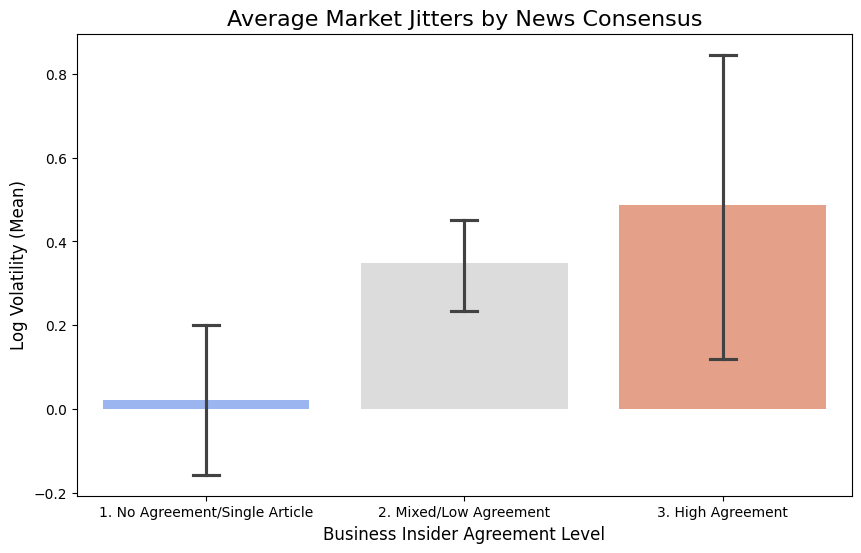

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create 3 simple categories manually to avoid the qcut error
def categorize_agreement(x):
    if x == 0: return "1. No Agreement/Single Article"
    if x < 0.5: return "2. Mixed/Low Agreement"
    return "3. High Agreement"

clean_data['agreement_group'] = clean_data['agreement_lag'].apply(categorize_agreement)

plt.figure(figsize=(10, 6))
sns.barplot(x='agreement_group', y='ln_vi_t', data=clean_data, palette='coolwarm', capsize=.1)

plt.title('Average Market Jitters by News Consensus', fontsize=16)
plt.xlabel('Business Insider Agreement Level', fontsize=12)
plt.ylabel('Log Volatility (Mean)', fontsize=12)
plt.show()

In [86]:
clean_data

,date,label,price,volume,dividend,dividend_dummy,log_return,log_return_lag,log_volume,bullishness_index,agreement_index,article_count,soxx_ret,bullishness_lag,agreement_lag,article_count_lag,abs_return,soxx_vol
753,2024-01-17,AMD,160.169998,104085000,0.0,0,0.896806,7.983279,18.460718,0.693147,0.020204,5.0,-0.920559,0.000000,0.000000,4.0,0.896806,0.920559
754,2024-01-18,AMD,162.669998,131864900,0.0,0,1.548786,0.896806,18.697288,0.000000,0.000000,11.0,3.247816,0.693147,0.020204,5.0,1.548786,3.247816
755,2024-01-19,AMD,174.229996,140367900,0.0,0,6.865264,1.548786,18.759777,1.098612,0.254644,3.0,3.836622,0.000000,0.000000,11.0,6.865264,3.836622
756,2024-01-22,AMD,168.179993,122973800,0.0,0,-3.534145,6.865264,18.627482,1.386294,0.072975,8.0,0.327123,1.098612,0.254644,3.0,3.534145,0.327123
757,2024-01-23,AMD,168.419998,76830500,0.0,0,0.142606,-3.534145,18.157112,0.287682,0.004141,11.0,0.660941,1.386294,0.072975,8.0,0.142606,0.660941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6274,2026-01-09,NVDA,184.860001,131327500,0.0,0,-0.097320,-2.175688,18.693205,1.704748,0.200000,15.0,2.838124,-0.405465,0.010257,14.0,0.097320,2.838124
6275,2026-01-12,NVDA,184.940002,137968500,0.0,0,0.043268,-0.097320,18.742536,1.098612,0.083485,15.0,0.476389,1.704748,0.200000,15.0,0.043268,0.476389
6276,2026-01-13,NVDA,185.809998,160128900,0.0,0,0.469317,0.043268,18.891490,0.405465,0.008929,15.0,0.889023,1.098612,0.083485,15.0,0.469317,0.889023
6277,2026-01-14,NVDA,183.139999,159586100,0.0,0,-1.447375,0.469317,18.888094,0.367725,0.011035,27.0,-0.420925,0.405465,0.008929,15.0,1.447375,0.420925


In [85]:
np.corrcoef(clean_data.log_return,clean_data.soxx_ret)

array([[1.        , 0.61663909],
       [0.61663909, 1.        ]])